In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

data = yf.download('AAPL', start='2020-01-01', end='2025-03-18', auto_adjust=False)

data = data[['Adj Close']]
data.rename(columns={'Adj Close': 'Close'}, inplace=True)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
data['Close'] = scaler.fit_transform(data[['Close']])

[*********************100%***********************]  1 of 1 completed


In [2]:
def create_sequences(dataset, lookback=60):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        X.append(dataset[i:(i + lookback), 0])
        y.append(dataset[i + lookback, 0])
    return np.array(X), np.array(y)

dataset = data.values

lookback = 60
X, y = create_sequences(dataset, lookback)

train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]


In [4]:
import torch

X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

X_train_tensor = X_train_tensor.unsqueeze(-1).permute(1, 0, 2)
X_test_tensor = X_test_tensor.unsqueeze(-1).permute(1, 0, 2)

In [5]:
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term) 
        pe[:, 1::2] = torch.cos(position * div_term)  
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return x
    

class TransformerTimeSeries(nn.Module):
    def __init__(self, feature_size=1, num_layers=2, nhead=4, hidden_dim=128, dropout=0.1):
        super(TransformerTimeSeries, self).__init__()
        self.model_type = 'Transformer'
        self.input_linear = nn.Linear(feature_size, hidden_dim)  # Added linear layer
        self.pos_encoder = PositionalEncoding(d_model=hidden_dim)
        encoder_layers = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, dim_feedforward=hidden_dim, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.decoder = nn.Linear(hidden_dim, 1)
        self.hidden_dim = hidden_dim

    def forward(self, src):
        # src shape: (seq_length, batch_size, feature_size)
        src = self.input_linear(src)  # Map input to hidden_dim dimensions
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        # Take the output of the last time step
        output = self.decoder(output[-1, :, :])
        return output


feature_size = 1  # Number of input features
num_layers = 2
nhead = 4
hidden_dim = 128

model = TransformerTimeSeries(feature_size=feature_size, num_layers=num_layers, nhead=nhead, hidden_dim=hidden_dim).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [6]:
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

num_epochs = 100
batch_size = X_train_tensor.size(1)

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output.squeeze(), y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 5 == 0:
        model.eval()
        with torch.no_grad():
            test_output = model(X_test_tensor)
            test_loss = criterion(test_output.squeeze(), y_test_tensor)
        print(f'Epoch [{epoch + 1}/{num_epochs}], train Loss: {loss.item():.4f}, test Loss: {test_loss.item():.4f}')

Epoch [5/100], train Loss: 0.7170, test Loss: 1.4196
Epoch [10/100], train Loss: 0.2068, test Loss: 0.0454
Epoch [15/100], train Loss: 0.0255, test Loss: 0.2257
Epoch [20/100], train Loss: 0.0806, test Loss: 0.2102
Epoch [25/100], train Loss: 0.0501, test Loss: 0.0157
Epoch [30/100], train Loss: 0.0192, test Loss: 0.0873
Epoch [35/100], train Loss: 0.0313, test Loss: 0.1182
Epoch [40/100], train Loss: 0.0183, test Loss: 0.0242
Epoch [45/100], train Loss: 0.0129, test Loss: 0.0437
Epoch [50/100], train Loss: 0.0134, test Loss: 0.0497
Epoch [55/100], train Loss: 0.0102, test Loss: 0.0138
Epoch [60/100], train Loss: 0.0077, test Loss: 0.0212
Epoch [65/100], train Loss: 0.0079, test Loss: 0.0122
Epoch [70/100], train Loss: 0.0072, test Loss: 0.0071
Epoch [75/100], train Loss: 0.0074, test Loss: 0.0088
Epoch [80/100], train Loss: 0.0069, test Loss: 0.0060
Epoch [85/100], train Loss: 0.0064, test Loss: 0.0066
Epoch [90/100], train Loss: 0.0064, test Loss: 0.0068
Epoch [95/100], train Loss: 0

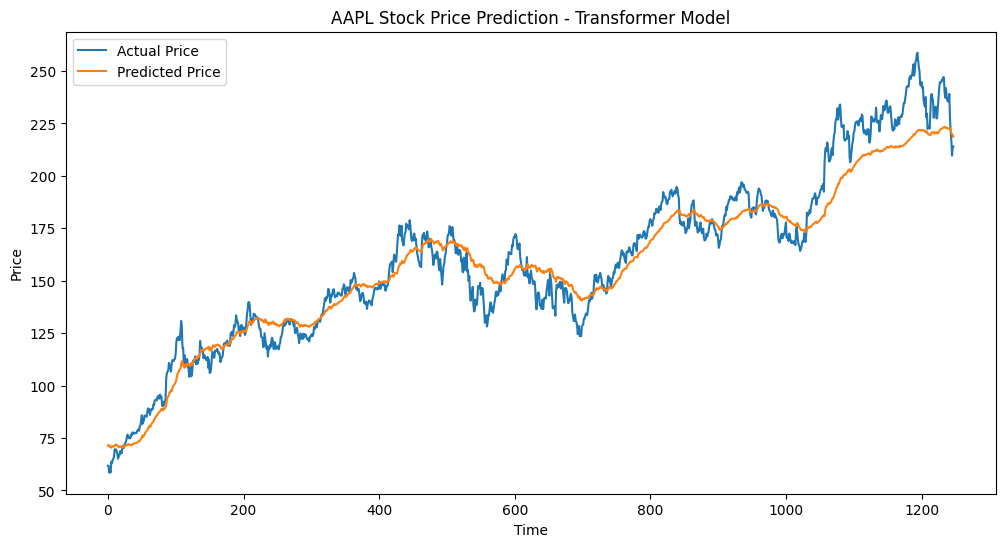

In [7]:
model.eval()
with torch.no_grad():
    train_predict = model(X_train_tensor).cpu().numpy()
    test_predict = model(X_test_tensor).cpu().numpy()

train_predict = scaler.inverse_transform(train_predict)
y_train_actual = scaler.inverse_transform(y_train_tensor.cpu().numpy().reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform(y_test_tensor.cpu().numpy().reshape(-1, 1))

predicted = np.concatenate((train_predict, test_predict), axis=0)
actual = scaler.inverse_transform(dataset[lookback:])
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(actual, label='Actual Price')
plt.plot(predicted, label='Predicted Price')
plt.title('AAPL Stock Price Prediction - Transformer Model')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [8]:
from sklearn.metrics import mean_squared_error

train_score = mean_squared_error(y_train_actual, train_predict)
test_score = mean_squared_error(y_test_actual, test_predict)
print(f'Train Score: {train_score}, Test Score: {test_score}')


Train Score: 64.58280944824219, Test Score: 322.48822021484375
